Curtis Sera <br>
v1.2.1

# Introduction: Fusion Pore Expansion Energetics

Calculating the total energy of the system as before pore formation, after the initial pore forms, and as the pore expands.  This is basically putting numbers to my Welch Lab/Work/"Pore on bent membrane" page.

*Assume:*
- Negligible **tension**
- Protrusion membrane is static outside of pore's local area (ie pore expansion velocity >> protrusion shape changes)
- *As the pore expands, the membrane it replaces "disappears" into a stress-free bulk*.  I picture this as the membrane material flowing out from the region the pore replaces and pushing neighboring membrane such that an equivalent area is lost to a zero-stress bulk
- **$K_b$** of a double bilayer structure w/ a bridging pore $\approx K_b$ of a double bilayer structure w/ simple apposition $\approx 2 K_b$ of a *single* bilayer structure
- ~**Distance between membranes** is held constant.  This is *not* going to be what actually happens since the minimal E solution also has $r_t$ increasing (see Chizmadzhev, 1995), but it greatly simplifies our calculations for now and will [hopefully] give a ballparks of the energies.~
    - Am now explicitly plotting over both $r_t$ and $r_{eff}$

My protrusion is a double bilayer bent into this shape: <br>
<img src="Imgs/protrusion_surface.jpg" width=300 /><br>
This is a piecewise surface of revolution wherein the base is a torus section, the body is a cylinder, and the cap is a hemisphere. 
Note that $z=0$ where the toroidal base's tangent plane is the xy plane.


Next, we need to designate some coordinates on this surface for the toroidal base.
System coordinates & parameters for the protrusion surface: <br>
<img src="Imgs/tor_base_coord.jpg" width=250 /> <img src="Imgs/tor_base_xsection.jpg" width=550 /><br>
An additional measure $L$ is the length of the protrusion measured from z=0 to the tip of the hemispherical cap.

System coordinates & parameters for the toroidal pore (neglecting membrane thickness and pore tilt, $\theta$, of 0): <br>
<img src="Imgs/pore_coord.jpg" width=250 /> <img src="Imgs/pore_xsection.jpg" width=550 /><br>
To make this more complete, we adapt Christoph & Rob's (2011) model of an inclined toroidal pore: <br>
<img src="Imgs/inclined_pore2_background.jpg" width=250 /> <br>
Note that UPPERCASE letters and the beginning of the Greek alphabet are used for the protrusion itself while lowercase letters and the end of the Greek alphabet are used for the pore.

***
# Set-up

In [5]:
import numpy as np
import sympy as sp
import plotly.graph_objs as go

# ---------------------------------------------------------------------
# Global system properties 
# ---------------------------------------------------------------------

# System properties: protrusion & bilayer
R0 = 375 # Radius of the protrusion's cylindrical body; in nm
L = 5000 # Protrusion length; in nm
KbPore = 15 # Bending constant of a generic bilayer; in kT
KbProtr = KbPore*2  # Bending constant of the double-membrane protrusion; in kT
    # Crude estimation that treats the double-bilayer structure as single unit
H0 = 0 # Membrane spontaneous curvature; in 1/nm
h = 7.5 # Bilayer thickness; in nm

# System properties: pore
rtMax = 40 # Max rt to compute for; 40 based on Chizmadzhev (1995); nm
rtSteps = rtMax*4
rt = np.linspace(1,rtMax,num=rtSteps) 
    # Radius of "fold" to form pore rim as meas from inner monolayer surface; in nm
    # Range starts at ~upper limit of intermembr distance for spontaneous fusion and 
    # extends to rtMax
m = h+rt # Distance b/w outer leaflet & intermembrane midplane; nm

# ---------------------------------------------------------------------
# Key equations/fxns for G calculation
# ---------------------------------------------------------------------
def helfrichStress(k1,k2,Kb):
    '''
    Helfrich bending *stress*
    
    Args:
        k1: (float) Principal curvature 1; 1/nm
        k2: (float) Principal curvature 2; 1/nm
        Kb: (float) Helfrich bending constant for membrane; kT
    Returns:
        (float) The Helfrich bending *stress* (ie energy for an infinitesimal dA) 
    '''
    return 0.5*Kb*(k1+k2)**2 # Note units = energy/unit area = kT/nm^2

def xi(r0,rtVal,mVal,theta):
    '''
    Core function as defined in Christoph's paper
    
    Args:
        r0: (float) Fusion pore radius meas from intermembrane midplane; nm
        rtVal: (float) Radius of "fold" to form pore rim; nm
        mVal: (float) h+rtVAl = dist b/w outer leaflet & intermemb midplane; nm
        theta: (float) Pore incline angle; radians
    Returns:
        (float) Val of fxn xi from Christoph's paper
    '''
    return (r0 + mVal*np.cos(theta))/rtVal;
            
def W(wXi,theta):
    '''
    Core function as defined in Christoph's paper
    
    Args:
        wXi: (float) Relevant value of xi
        theta: (float) Pore incline angle; radians
    Returns:
        (float) Val of fxn W from Christoph's paper
    '''
    xiSqr = wXi**2
    sqrtXiSqr = np.sqrt(xiSqr - 1)
    
    return ( (2*xiSqr)/sqrtXiSqr * (np.arctan((np.tan(theta/2 + np.pi/4) * sqrtXiSqr)/(wXi-1))
            - np.arctan((np.tan(theta/2) * sqrtXiSqr)/(wXi-1))) )

def T(tXi,rtVal,theta):
    '''
    Core function as defined in Christoph's paper
    
    Args:
        tXi: (float) Relevant value of xi
        rtVAl: (float) Radius of "fold" to form pore rim; nm
        theta: (float) Pore incline angle; radians
    Returns:
        (float) Val of fxn T from Christoph's paper
    '''
    cosTheta = np.cos(theta)
    
    return ( -4*cosTheta - H0*rtVal*(np.pi*tXi - 4*cosTheta)
            + H0**2 * rtVal**2 * (np.pi*tXi/2 - cosTheta) )

def GPore(r0,rtVal,mVal,theta,Kb):
    '''
    Calculates energy of an inclined toroidal fusion pore from Christoph's 2011 paper
    
    Args:
        r0: (float) Fusion pore radius meas from intermembrane midplane; nm
        rtVal: (float) Radius of "fold" to form pore rim; nm
        mVal: (float) h+rtVAl = dist b/w outer leaflet & intermemb midplane; nm
        theta: (float) The angle of pore incline; radians
        Kb: (float) Helfrich bending constant for membrane; kT
    Returns:
        (float) The bending energy for an inclined toroidal pore; units set by Kb
    '''
    thisXi = xi(r0,rtVal,mVal,theta)
    return np.pi * Kb * (W(thisXi,theta) + W(thisXi,-theta) + 2*T(thisXi,rtVal,theta))

print("done")

done


# Pore at hemispherical tip
For modeling simplicity (ie symmetry), I'll stick the pore at the very end of the protrusion where the hemispherical cap comes to its apex.  Thus, this is essentially just the pore at the apex of a hemisphere.  

I could track the pore expansion until it consumes the whole cap.  However, my assumption of constant (!= uniform) distance b/w membranes will probably start to cause major deviations at that point.  I'll restrict my analysis to ~50 nm since Chizmadzhev et al (1995) found that total pore E starts decreasing after that point due to alleviation of bending stress via intermembrane distance widening.

*Assume:*
- Membrane is locally conical around pore
- Radially symmetric expansion of the pore since it's at the pole of a uniformly stressed hemisphere 
- Deformations around the pore (ie increasing rt) remain localized do not meaningfully alter the rest of the protrusion's shape/energy.  Note that this can either be interpreted to mean that the inner bilayer and outer bilayer are uniformly moving farther apart as rt increases or that there's a boundry of convex membrane surrounding the pore that we are neglecting in our calculations.  I will be using the latter interpretation.

The total system energy is simply the combined bending energies $G_{pore} + G_{cap}$.  We can calculate the pore energy from Christoph's solution to the inclined toroidal pore as set up above.  Using the assumptions above, the cap stress profile will be held uniform and static so $G_cap$ is just the stress times whatever cap area remains as the pore expands.  
To find the remaining cap area as the pore expands, we use the solution to Archimedes's hat-box:<br>
<img src='Imgs/sphere_belt_area.jpg' width=400> <br>
The area of the light blue belt is equal to the area of the vertical walls of cylinder on the right.  Thus,
    $A = 2\pi r h$,
or in my standardized notation: <br>
    $A = 2\pi R_0 h_{band}$
    
To find $h$, we need to examine the pore and do some trig. <br>
<img src='Imgs/protrusion_pore_tilt.jpg' width=250> <br>
From 'Inclined fusion pore.ipynb', we know: <br>
    $\theta = arcsin(\frac{r_0}{R_0})$ <br>
where $r_0$ is the pore radius and $R_0$ is the protrusion radius.  Knowing $\theta$, we can find $h$: <br>
    $h_{band} = R_0 cos(\theta) = \frac{r}{tan(\theta)}$

Additionally, the pore energy will be graphed over the "effective pore radius", $r_{eff}$.  This is defined as the minimum pore radius for a given $\theta$ and is depicted below: <br>
<img src='Imgs/inclined_pore_r_eff.jpg' width=250> <br>
From the image above, we find that $r_{eff}$ is related to $r_0$ by the equation: <br>
$r_0 = r_e + c = r_e + m - m cos(\theta) = r_e + m (1 - cos(\theta))$

nStep =  501
Computing energies
Max GTotCap =  8755.268099864745
Finding minimum path
rt indices of min path = [  0  48  48  49  50  50  51  52  52  53  54  55  55  56  57  57  58  59
  59  60  61  61  62  63  63  64  65  65  66  67  67  68  69  69  70  71
  72  72  73  74  74  75  76  76  77  78  78  79  80  80  81  82  82  83
  84  84  85  86  87  87  88  89  89  90  91  91  92  93  93  94  95  95
  96  97  97  98  99  99 100 101 102 102 103 104 104 105 106 106 107 108
 108 109 110 110 111 112 112 113 114 114 115 116 117 117 118 119 119 120
 121 121 122 123 123 124 125 125 126 127 127 128 129 129 130 131 131 132
 133 134 134 135 136 136 137 138 138 139 140 140 141 142 142 143 144 144
 145 146 146 147 148 149 149 150 151 151 152 153 153 154 155 155 156 157
 157 158 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159
 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159
 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159
 159 159 159 

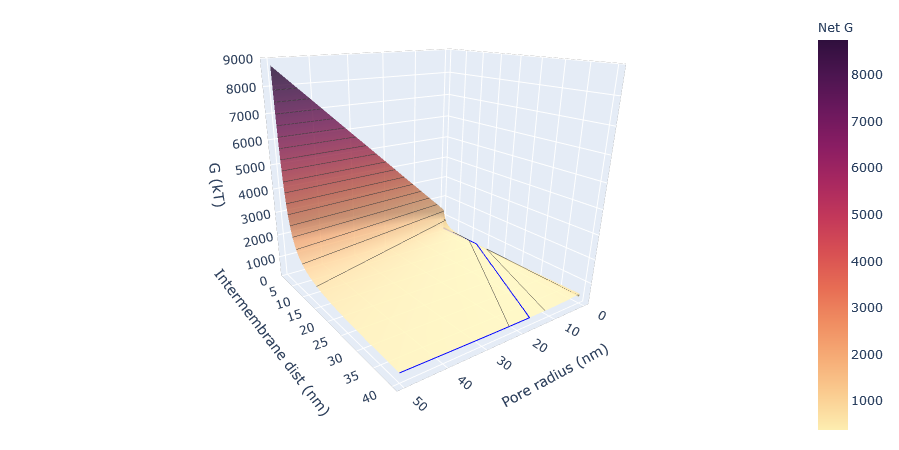

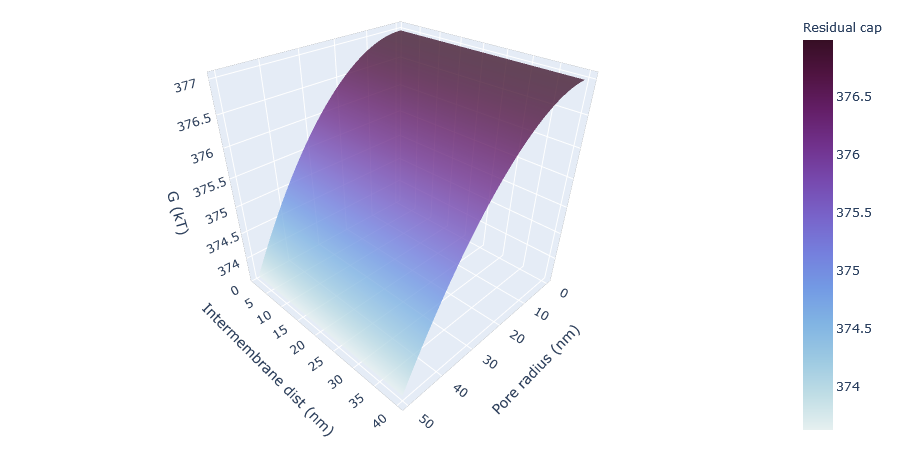

done


In [32]:
# ---------------------------------------------------------------------
# Computation: bending energy of the initial hemispherical tip
# ---------------------------------------------------------------------

# Sim param
#rEffCapInit = 1 # initial effective pore radius in cap; nm
#rtInit = 1 # initial r_t; nm
stepSize = 0.1 # Step size of pore radius dilation; nm
max_r = 50 # Maximum pore radius to do computations for; nm
nStep = int(np.ceil(max_r/stepSize + 1)) # Num steps to take over expanding rEffCap
    # +1 so that I preserve num of steps after adding initial values
print("nStep = ",nStep)

# Set up the arrays of size rtSteps x nStep to hold my computations
GCap = np.zeros((rtSteps,nStep)) # Bending *energy* of all non-pore membrane in the cap; kT
GCapPore = np.zeros((rtSteps,nStep)) # Energy of the fusion pore (Helfrich bending only); kT
GTotCap = np.zeros((rtSteps,nStep)) # Total Gb of cap = GCap + GCapPore; kT
rEffCap = np.linspace(0,max_r,num=nStep) # Effective radius of pore; nm
    # This is the pore radius at the narrowest point which < r0 if theta != 0
    # Note: linspace is start and end point inclusive by default. 
    # Thus there are nStep-2 evenly spaced points in the open interval (0,max_r)
GMinPath = np.zeros((nStep,3)) # Coordinates for the min G path
    # 0 = x (ie rEffCap), 1 = y (ie rt), 2 = z (GTotCap) 

# Set/Compute initial conditions for referencing in computations
# Note that array[:,n] refs calumn n in all rows in array
stressCap = helfrichStress(1/R0,1/R0,KbProtr) # The static, uniform stress of the cap membrane
GCap[:,0] = 2*np.pi*(R0**2) * stressCap # Init Gb of cap; kT
    # is ACap * CapStress where ACap == SA of a hemisphere of radius R
GCapPore[:,0] = 0
GTotCap[:,0] = GCap[0,0]+GCapPore[0,0]

# Find GCap, GCapPore, and thus GTotCap for each value of rt and rCapPore
# First iterate over rCapPore then rt; nesting order doesn't matter since everything uses both
print("Computing energies")
for i in range(1,nStep):
    for rtIndex in range(0,rtSteps):
        #Vars for each iteration of loop
        theta = np.arcsin(rEffCap[i]/R0) # Angle of pore incline == angle from z axis; radians
            # For theta, neglect difference b/w r0 and rEffCap[i]
        r0 = rEffCap[i] + m[rtIndex]*(1-np.cos(theta)) # r0 as defined in the figures in the set-up
            # What we actually plug into Christoph & Rob's solution
        hBand = R0*np.cos(theta)
        #print("hBand(",i,") = ",hBand)

        # Find Gb of remaining cap
        A = 2*np.pi*R0*hBand # Area of remaining cap
        GCap[:,i] = A*stressCap
        
        # Find Gb of the inclined pore
        GCapPore[rtIndex,i] = GPore(r0,rt[rtIndex],m[rtIndex],theta,KbPore)
#         print("r0",r0,"; rt",rt[rtIndex],"; m",m[rtIndex],": theta",theta,"; KbPore",KbPore)
#         print(GPore(r0,rt[rtIndex],m[rtIndex],theta,KbPore))
        GTotCap[rtIndex,i] = GCap[rtIndex,i]+GCapPore[rtIndex,i]
print("Max GTotCap = ",np.max(GTotCap))

# ---------------------------------------------------------------------
# Find MINimal G expansion path
# ---------------------------------------------------------------------
# Want to find the least energetically costly path for pore expansion on the surface I just found
# Option 1: Water flow pathfinding
# Set start point @ (rEffCap=4, rt=1); rEffCap = expected hemifusion diaphragm radius
# Thus, we are starting just after hemifusion diaphragm consumption with the membranes still at
# the critical distance.
# To find the "minimal G expansion path", we'll req rEffCap to incr w/ each step and find the val 
# of rt that gives the smallest incr in GTotCap
# Option 2: Min with respect to rEffCap
# Simply find the rt value with the minimum GTotCap for each rEffCap slice
# 
# I'm not sure that opt 1 will work the way I intend it to given the surface shape, so I'll do
# option 2

print("Finding minimum path")

# Find min path
GMinPathIndex = np.argmin(GTotCap,axis=0) #Arr of indices of min GTotCap in each row
print("rt indices of min path =",GMinPathIndex)

# Get data for min path
for i in range(0,nStep):
    GMinPath[i,0] = rEffCap[i]
    GMinPath[i,1] = rt[GMinPathIndex[i]]
#     print(GMinPathIndex[i])
#     print(rt[GMinPathIndex[i]])
#     print(GTotCap[GMinPathIndex[i],i])
    GMinPath[i,2] = GTotCap[GMinPathIndex[i],i]

# ---------------------------------------------------------------------
# Graph the results for the cap pore
# ---------------------------------------------------------------------
print("Graphing results")
totCapSurf = go.Figure()
# Graph GTotCap (GCap + GPore) surface
totCapSurf.add_trace(go.Surface(
    #coloraxis=go.layout.Coloraxis(dict(
    #    title="Neg G", "coloraxis1")),
    colorbar=go.surface.ColorBar(title='Net G'),
    colorscale='matter',
    contours={"z":{"show":True,"start":np.max(GTotCap)/20,"end":np.max(GTotCap)*0.95,
                   "size":np.max(GTotCap)/20}},
    name='Net G',
    x=rEffCap,y=rt,z=GTotCap,opacity=0.9))
# Graph curve of min GTotCap for expanding rEffCap
totCapSurf.add_trace(go.Scatter3d(
    marker=dict(
        color='blue',
        size=2),
    mode='lines',
    name='Min G path',
    x=GMinPath[:,0],y=GMinPath[:,1],z=GMinPath[:,2]))
totCapSurf.update_layout(coloraxis_showscale=False,
    scene = dict(
                    xaxis_title='Pore radius (nm)',
                    yaxis_title='Intermembrane dist (nm)',
                    zaxis_title='G (kT)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
totCapSurf.show()

bendCapSurf = go.Figure()
# Graph GCap component of GTotCap surface
bendCapSurf.add_trace(go.Surface(
    #coloraxis=go.layout.Coloraxis("coloraxis2"),
    colorbar=go.surface.ColorBar(title='Residual cap'),
    colorscale='dense',
    contours={"z":{"show":True,"start":np.max(GCap)/2,"end":np.max(GCap)*0.9,
                   "size":np.max(GCap)/5}},
    name="Residual cap",
    x=rEffCap,y=rt,z=GCap,opacity=0.9))
bendCapSurf.update_layout(coloraxis_showscale=False,
    scene = dict(
                    xaxis_title='Pore radius (nm)',
                    yaxis_title='Intermembrane dist (nm)',
                    zaxis_title='G (kT)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
bendCapSurf.show()


# capGraph = go.Figure()
# capGraph.add_trace(go.Scatter(x=rEffCap, y=GTotCap, name=r"Total Cap G",
#                         mode='lines'))
# capGraph.add_trace(go.Scatter(x=rEffCap, y=GCapPore, name=r"Pore G",
#                         line=dict(dash='dash'),
#                         mode='lines'))
# capGraph.add_trace(go.Scatter(x=rEffCap, y=GCap, name=r"Cap bending G",
#                         line=dict(dash='dash'),
#                         mode='lines'))
# # Some quick figure styling
# capGraph.update_layout(title="Cap pore energies",
#                   xaxis_title=r"$r_{eff}$", yaxis_title=r"$G (kT)$",
#                   autosize=False, width=600, height=600)
# capGraph.show()

print('done')

The minimum energy curve shown in the plot of total net energy reveals a subtle "valley" in the pore radius range of [0 nm, ~17 nm].  This low energy "valley" is easily missed when looking at the surface by eye alone.

Note: Under the current simulation conditions, the program runs into the rt ceiling of 40 nm by $rEffCap \approx 17 nm$.  I don't think that I should really expand the rt range further though.  At rt = 40 nm, my hemispherical symetry has already started to break down, so my results would probably start really to diverge from reality if I extrapolated that far.

# Pore in toroidal base

Ignore this for now

*Note: My definition for $\beta$ is shifted by $\pi$ radians from the one used to derive the curvature.  Therefore, I need to recalculate the curvature to shift the angle I plug in forward by $\pi$ radians.*

In [ ]:
# System properties
# R, the radius of protrusion's cylindrical body, is defined as in the first section
#rt = 200 # Radius of the torus tube/circle revolved around z for the base; in nm

# Model curvatures
#krt = 1/rt # Curvature from the circle revolved about z to make the torus

#def kT(z):
    '''
    Curvature as beta changes (moving around the minor circle of the tube)
    
    Args:
        z: (float) The distance from the torus floor
    Returns:
        (float) The curvature from the torus's minor ring
    '''
    #return np.sqrt(1 - ((rt - z)/rt)**2)/(R + rt + rt np.sqrt(1 - ((rt - z)/rt)**2))

# References - Papers

- CA Haselwandter & R Phillips. Elastic energy of polyhedral bilayer vesicles. *Phys Rev E*. 83:061901 (2011). [DOI 10.1103/PhysRevE.83.061901](http://dx.doi.org/10.1103/PhysRevE.83.061901)
- YA Chizmadzhev, FS Cohen, A Shcherbakov, J Zimmerberg. Membrane mechanics can account for fusion pore dilation in stages. *Biophys J*. 69:2489-2500 (1995). [DOI 10.1016/S0006-3495(95)80119-0](https://doi.org/10.1016/S0006-3495(95)80119-0)

# References - Coding
- Plotly color schemes:
    - https://plotly.com/python/builtin-colorscales/
    - https://plotly.com/python/colorscales/
    - https://community.plotly.com/t/using-greek-letter-in-surface-name-and-colorbar-name/5023
    - https://community.plotly.com/t/conditional-colormap-in-3d-surface/19307
    - https://plotly.com/python/3d-surface-coloring/
- Plotly surfaces & 3D:
    - https://plotly.com/python/3d-surface-plots/
    - https://plotly.com/python-api-reference/generated/plotly.graph_objects.Surface.html
    - https://plotly.com/python/3d-axes/
    - https://plotly.com/python/3d-isosurface-plots/
- Misc Plotly formatting:
    - Both about Greek letters in 3D plots & ex of mult color bars: https://community.plotly.com/t/using-greek-letter-in-surface-name-and-colorbar-name/5023
    - https://plotly.com/python-api-reference/generated/plotly.graph_objects.Layout.html